Project : Develop model to detect deepfake video with Highest accuracy (possible by us) which has explainability . Will try to create few model to generate comparisons for comparison and then picking one final one as our "final model".

Business Value: Flagging misinformation/ protecting digital identity

In [2]:
# # Deep Fake Detection Project
# ## Complete Pipeline: Data Analysis → Feature Engineering → Model Training → Hyperparameter Tuning
#
# **Dataset**: Google Drive - Celeb-Real, Celeb-Fake, and Testing folders
# - **Celeb-Real**: Real/Original videos (Label: 0, "Celeb-Real")
# - **Celeb-Fake**: Fake/Manipulated videos (Label: 1, "Fake")
# - **Testing**: Test videos for evaluation
#
# **Dataset Link**: https://drive.google.com/drive/folders/1nBKjUpi2wQyMfWDuNsreqY11DVZrbk7x
#
# **Objective**: Detect original vs AI-generated images and videos
#
# **Approach**:
# - Comprehensive EDA
# - Feature engineering (spatial, frequency, texture features)
# - Multiple CNN architectures + Transfer Learning
# - Hyperparameter optimization
# - Model evaluation and comparison
#
%pip install optuna
%pip install gdown
# Note: torchcodec is not needed - we use OpenCV for video processing
# %%
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, models
import timm
# torchcodec not needed - using OpenCV for video processing instead
# import torchcodec  # Optional: requires FFmpeg installation

# Computer Vision
import cv2
from PIL import Image
from skimage import feature, filters
from skimage.feature import local_binary_pattern

# ML & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import StandardScaler

# HuggingFace
from datasets import load_dataset

# Hyperparameter Tuning
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Utilities
from tqdm.auto import tqdm
import time
from datetime import datetime
import json
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Using CPU - training will be slower")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Using device: cpu
Using CPU - training will be slower


LOADING DATASET FROM GOOGLE DRIVE FOLDERS
Note: you may need to restart the kernel to use updated packages.
Project root: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project
Data directory: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data
Data directory exists: True

CHECKING FOR LOCAL DATASET FOLDERS

📁 Contents of data directory (/Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data):
   📄 .DS_Store
   📁 Celeb-real
   📁 Celeb-synthesis
   📁 Testing

[INFO] Looking for dataset folders...
Celeb-Real folder: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data/Celeb-Real
Celeb-Fake folder: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data/Celeb-synthesis
Testing folder: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data/Testing
✅ Dataset folders found locally!

LOADING VIDEOS FROM FOLDERS
   ✅ Loaded 493 videos from Celeb-R

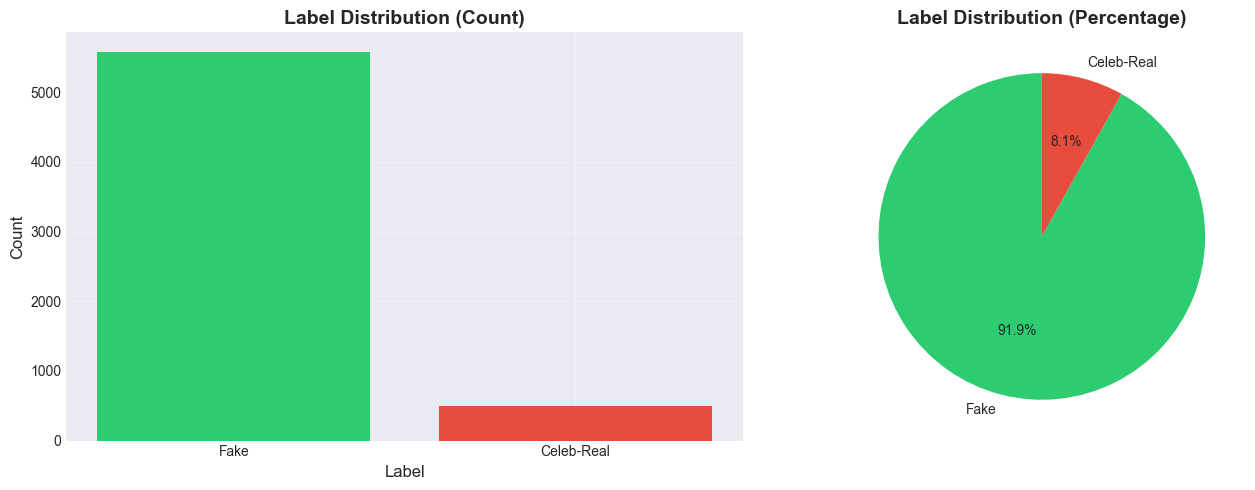


✓ Training dataset loaded: 6075 videos
✓ Test dataset loaded: 15 videos


In [5]:
# ## 2. Data Loading from Local Folders
# Dataset Structure (in data/ directory):
# - Celeb-real/ or Celeb-Real/: Real videos (label: 0, "Celeb-Real")
# - Celeb-synthesis/ or Celeb-Fake/: Fake videos (label: 1, "Fake")
# - Testing/: Test videos (for evaluation)
#
# The code automatically finds folders with case-insensitive matching.
# Your actual folder names: Celeb-real, Celeb-synthesis, Testing

print("="*80)
print("LOADING DATASET FROM GOOGLE DRIVE FOLDERS")
print("="*80)

# Install gdown for downloading from Google Drive
%pip install gdown

import gdown
from pathlib import Path
import glob

# Set up data directory - using absolute path from project root
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")

# Google Drive folder IDs (extracted from the share link)
GOOGLE_DRIVE_FOLDER_ID = "1nBKjUpi2wQyMfWDuNsreqY11DVZrbk7x"

# Try to find folders with case-insensitive matching
def find_folder(base_dir, possible_names):
    """Find folder with case-insensitive matching"""
    base_dir = Path(base_dir)
    if not base_dir.exists():
        return None
    
    # First try exact match
    for name in possible_names:
        folder = base_dir / name
        if folder.exists() and folder.is_dir():
            return folder
    
    # Then try case-insensitive match
    for item in base_dir.iterdir():
        if item.is_dir():
            item_lower = item.name.lower()
            for name in possible_names:
                if item_lower == name.lower():
                    return item
    
    return None

# Find folders with various possible names
# Note: Actual folder names may vary (Celeb-real, Celeb-synthesis, etc.)
CELEB_REAL_FOLDER = find_folder(DATA_DIR, [
    "Celeb-Real", "celeb-real", "Celeb-real", "Celeb_Real", "celeb_real", 
    "CelebReal", "Celeb-Real", "real", "Real"
])
CELEB_FAKE_FOLDER = find_folder(DATA_DIR, [
    "Celeb-Fake", "celeb-fake", "Celeb-fake", "Celeb_Fake", "celeb_fake", 
    "CelebFake", "Celeb-synthesis", "celeb-synthesis", "Celeb-Synthesis",
    "synthesis", "Synthesis", "fake", "Fake"
])
TESTING_FOLDER = find_folder(DATA_DIR, ["Testing", "testing", "Test", "test"])

def download_from_google_drive(folder_id, output_dir):
    """Download folder from Google Drive using gdown"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"Downloading from Google Drive folder: {folder_id}")
    print(f"Output directory: {output_dir}")
    
    # Download folder as zip
    url = f"https://drive.google.com/drive/u/0/folders/{folder_id}"         # f"https://drive.google.com/uc?id={folder_id}"
    zip_path = output_dir / "dataset.zip"
    
    try:
        gdown.download_folder(url, output=str(output_dir), quiet=False, use_cookies=False)
        print(f"✅ Downloaded to {output_dir}")
        return True
    except Exception as e:
        print(f"⚠️  Download error: {e}")
        print("Please download manually from:")
        print(f"https://drive.google.com/drive/folders/{folder_id}")
        print(f"Extract to: {output_dir}")
        return False

def load_videos_from_folder(folder_path, label, label_name):
    """Load all video files from a folder"""
    folder_path = Path(folder_path)
    if not folder_path.exists():
        return []
    
    # Supported video formats
    video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv', '*.flv', '*.wmv', '*.webm']
    video_files = []
    
    for ext in video_extensions:
        video_files.extend(glob.glob(str(folder_path / "**" / ext), recursive=True))
    
    # Create data entries
    data_list = []
    for video_path in video_files:
        data_list.append({
            'video_path': video_path,
            'label': label,
            'label_name': label_name,
            'folder': folder_path.name
        })
    
    return data_list

# Download or check for local dataset
print("\n" + "="*80)
print("CHECKING FOR LOCAL DATASET FOLDERS")
print("="*80)

# List all items in data directory
if DATA_DIR.exists():
    print(f"\n📁 Contents of data directory ({DATA_DIR}):")
    items = list(DATA_DIR.iterdir())
    if items:
        for item in sorted(items):
            item_type = "📁" if item.is_dir() else "📄"
            print(f"   {item_type} {item.name}")
    else:
        print("   (empty)")
else:
    print(f"\n⚠️  Data directory does not exist: {DATA_DIR}")

print(f"\n[INFO] Looking for dataset folders...")
print(f"Celeb-Real folder: {CELEB_REAL_FOLDER}")
print(f"Celeb-Fake folder: {CELEB_FAKE_FOLDER}")
print(f"Testing folder: {TESTING_FOLDER}")

# Check if folders exist locally
if CELEB_REAL_FOLDER is None or CELEB_FAKE_FOLDER is None:
    print("\n[INFO] Dataset folders not found locally.")
    print("Attempting to download from Google Drive...")
    print("Note: If download fails, please download manually and place folders in 'data/' directory")
    
    # Try to download (this might not work for large folders, manual download recommended)
    download_success = download_from_google_drive(GOOGLE_DRIVE_FOLDER_ID, DATA_DIR)
    
    if not download_success:
        print("\n" + "="*80)
        print("MANUAL DOWNLOAD REQUIRED")
        print("="*80)
        print("Please follow these steps:")
        print(f"1. Open: https://drive.google.com/drive/folders/{GOOGLE_DRIVE_FOLDER_ID}")
        print("2. Download the three folders: Celeb-Real, Celeb-Fake, Testing")
        print(f"3. Extract them to: {DATA_DIR.absolute()}")
        print("4. Ensure folder structure:")
        print(f"   {DATA_DIR}/Celeb-Real/")
        print(f"   {DATA_DIR}/Celeb-Fake/")
        print(f"   {DATA_DIR}/Testing/")
        print("\nThen re-run this cell.")
else:
    print("✅ Dataset folders found locally!")

# Load videos from folders
print("\n" + "="*80)
print("LOADING VIDEOS FROM FOLDERS")
print("="*80)

# Load training data (Celeb-Real and Celeb-Fake)
train_data_list = []
if CELEB_REAL_FOLDER and CELEB_REAL_FOLDER.exists():
    real_videos = load_videos_from_folder(CELEB_REAL_FOLDER, label=0, label_name="Celeb-Real")
    train_data_list.extend(real_videos)
    print(f"   ✅ Loaded {len(real_videos)} videos from {CELEB_REAL_FOLDER.name} folder (Label: 0, 'Celeb-Real')")
else:
    print("   ⚠️  Celeb-Real folder not found or empty")
    print(f"   Expected folder names: Celeb-Real, celeb-real, Celeb-real, etc.")

if CELEB_FAKE_FOLDER and CELEB_FAKE_FOLDER.exists():
    fake_videos = load_videos_from_folder(CELEB_FAKE_FOLDER, label=1, label_name="Fake")
    train_data_list.extend(fake_videos)
    print(f"   ✅ Loaded {len(fake_videos)} videos from {CELEB_FAKE_FOLDER.name} folder (Label: 1, 'Fake')")
else:
    print("   ⚠️  Celeb-Fake folder not found or empty")
    print(f"   Expected folder names: Celeb-Fake, Celeb-synthesis, celeb-fake, etc.")

# Load test data (Testing folder)
if TESTING_FOLDER and TESTING_FOLDER.exists():
    test_data_list = load_videos_from_folder(TESTING_FOLDER, label=None, label_name="Testing")
    print(f"   Loaded {len(test_data_list)} videos from Testing folder")
else:
    test_data_list = []
    print("   ⚠️  Testing folder not found or empty (optional for training)")

# Convert to DataFrame for analysis
train_df = pd.DataFrame(train_data_list)
test_df = pd.DataFrame(test_data_list)

print(f"\n✅ Training videos loaded: {len(train_df)}")
print(f"✅ Test videos loaded: {len(test_df)}")

if len(train_df) > 0:
    print("\n" + "="*80)
    print("LABEL DISTRIBUTION ANALYSIS (Training Data)")
    print("="*80)
    print(f"\nTotal training samples: {len(train_df)}")
    print(f"\nLabel Distribution:")
    print(train_df['label_name'].value_counts())
    print(f"\nLabel Percentages:")
    print(train_df['label_name'].value_counts(normalize=True) * 100)
    
    # Check if we have both classes
    unique_labels = train_df['label'].unique()
    print(f"\nUnique labels found: {unique_labels}")
    
    if len(unique_labels) == 1:
        print("\n⚠️  WARNING: Only one class found in the dataset!")
        print(f"   All samples are labeled as: {train_df['label_name'].iloc[0]}")
    else:
        print("\n✓ Both classes found in the dataset!")
        print("   The dataset contains both Celeb-Real and Fake videos.")
    
    # Show sample paths
    print("\n" + "="*80)
    print("SAMPLE PATHS (First 10):")
    print("="*80)
    for idx, row in train_df.head(10).iterrows():
        print(f"Sample {idx}: {row['label_name']}")
        print(f"  Path: {row['video_path']}")
    
    # Visualize label distribution
    if len(train_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Count plot
        label_counts = train_df['label_name'].value_counts()
        axes[0].bar(label_counts.index, label_counts.values, color=['#2ecc71', '#e74c3c'])
        axes[0].set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Label', fontsize=12)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].grid(True, alpha=0.3)
        
        # Pie chart
        colors = ['#2ecc71', '#e74c3c']
        axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
                   colors=colors[:len(label_counts)], startangle=90)
        axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('label_distribution_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"\n✓ Training dataset loaded: {len(train_df)} videos")
    print(f"✓ Test dataset loaded: {len(test_df)} videos")
else:
    print("\n⚠️  No training videos found!")
    print("Please ensure the dataset folders are downloaded and placed in the 'data/' directory.")


In [6]:
# Additional analysis: Check dataset structure and video files
print("="*80)
print("DATASET STRUCTURE ANALYSIS")
print("="*80)

if 'train_df' in locals() and len(train_df) > 0:
    print(f"\n✅ Training Dataset Structure:")
    print(f"   Total videos: {len(train_df)}")
    print(f"   Columns: {train_df.columns.tolist()}")
    print(f"\n   Label distribution:")
    print(train_df['label_name'].value_counts())
    
    # Check video file formats
    print(f"\n📹 Video File Formats:")
    train_df['extension'] = train_df['video_path'].apply(lambda x: Path(x).suffix.lower())
    print(train_df['extension'].value_counts())
    
    # Sample video paths by label
    print(f"\n📁 Sample Video Paths by Label:")
    for label_name in train_df['label_name'].unique():
        print(f"\n   {label_name} videos:")
        sample_paths = train_df[train_df['label_name'] == label_name]['video_path'].head(3)
        for path in sample_paths:
            print(f"     - {Path(path).name}")
    
    if 'test_df' in locals() and len(test_df) > 0:
        print(f"\n✅ Test Dataset Structure:")
        print(f"   Total test videos: {len(test_df)}")
        print(f"   Test videos are in: {TESTING_FOLDER}")
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Training: {len(train_df)} videos")
    print(f"   Testing: {len(test_df) if 'test_df' in locals() else 0} videos")
    print(f"   Total: {len(train_df) + (len(test_df) if 'test_df' in locals() else 0)} videos")
else:
    print("⚠️  Dataset not loaded. Please run the previous cell first.")
    print("Make sure the dataset folders are downloaded and placed in the 'data/' directory.")


DATASET STRUCTURE ANALYSIS

✅ Training Dataset Structure:
   Total videos: 6075
   Columns: ['video_path', 'label', 'label_name', 'folder']

   Label distribution:
label_name
Fake          5582
Celeb-Real     493
Name: count, dtype: int64

📹 Video File Formats:
extension
.mp4    6075
Name: count, dtype: int64

📁 Sample Video Paths by Label:

   Celeb-Real videos:
     - id51_0004.mp4
     - id27_0005.mp4
     - id13_0007.mp4

   Fake videos:
     - id31_id1_0007.mp4
     - id28_id22_0001.mp4
     - id33_id20_0003.mp4

✅ Test Dataset Structure:
   Total test videos: 15
   Test videos are in: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data/Testing

📊 Dataset Summary:
   Training: 6075 videos
   Testing: 15 videos
   Total: 6090 videos


Testing video frame extraction...
Sample video: /Users/mohini.gangaram/Desktop/MLPostGrad/Sem3/Deep Learning/Final Project/data/Celeb-Real/id51_0004.mp4
✅ Frame extracted successfully!
   Frame shape: (478, 856, 3)


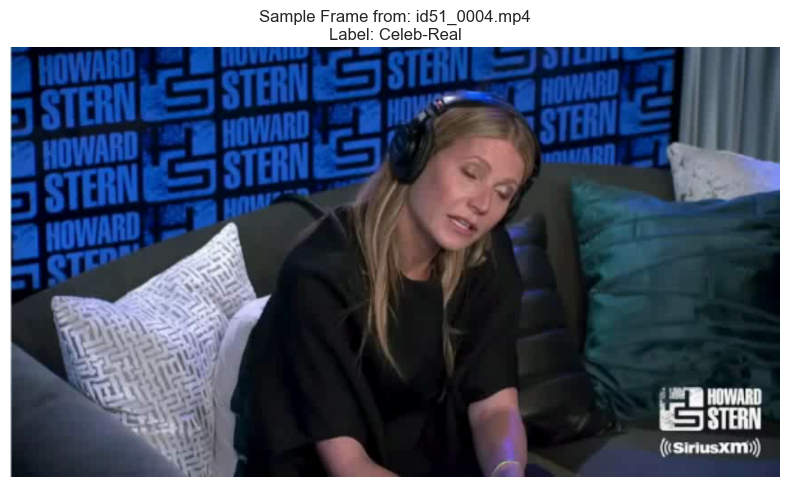

In [7]:
# Helper function to extract frame from video file
def extract_frame_from_video(video_path, frame_idx=0):
    """Extract a frame from video file path"""
    try:
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return None
        
        # Get total frames
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Set frame position
        if frame_idx >= total_frames:
            frame_idx = total_frames - 1
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()
        
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            return frame_rgb
        else:
            return None
    except Exception as e:
        print(f"Error extracting frame from {video_path}: {e}")
        return None

# Test video loading
if 'train_df' in locals() and len(train_df) > 0:
    print("Testing video frame extraction...")
    sample_video = train_df.iloc[0]['video_path']
    print(f"Sample video: {sample_video}")
    
    frame = extract_frame_from_video(sample_video, frame_idx=0)
    if frame is not None:
        print(f"✅ Frame extracted successfully!")
        print(f"   Frame shape: {frame.shape}")
        
        # Display sample frame
        plt.figure(figsize=(8, 6))
        plt.imshow(frame)
        plt.title(f"Sample Frame from: {Path(sample_video).name}\nLabel: {train_df.iloc[0]['label_name']}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('sample_video_frame.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("⚠️  Could not extract frame. Check video file format.")
else:
    print("⚠️  No training data available. Please load dataset first.")


In [8]:
# PyTorch Dataset Class for Video Loading
class VideoDataset(Dataset):
    """
    Custom PyTorch Dataset for loading videos from local folders.
    Labels are assigned based on folder location:
    - Celeb-Real folder → Label 0 ("Celeb-Real")
    - Celeb-Fake folder → Label 1 ("Fake")
    """
    
    def __init__(self, dataframe, transform=None, num_frames=16, frame_interval=1):
        """
        Args:
            dataframe: DataFrame with columns ['video_path', 'label', 'label_name', 'folder']
            transform: Optional transform to be applied on frames
            num_frames: Number of frames to extract from each video
            frame_interval: Interval between frames (1 = consecutive frames)
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.num_frames = num_frames
        self.frame_interval = frame_interval
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        video_path = self.dataframe.iloc[idx]['video_path']
        label = self.dataframe.iloc[idx]['label']
        label_name = self.dataframe.iloc[idx]['label_name']
        folder = self.dataframe.iloc[idx]['folder']
        
        # Extract frames from video
        frames = self.extract_frames(video_path)
        
        # Apply transforms if provided
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        # Convert list of frames to tensor
        # Stack frames: [num_frames, C, H, W]
        frames_tensor = torch.stack(frames)
        
        return {
            'frames': frames_tensor,
            'label': torch.tensor(label, dtype=torch.long),
            'label_name': label_name,
            'folder': folder,
            'video_path': video_path
        }
    
    def extract_frames(self, video_path):
        """Extract frames from video file"""
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        # Calculate frame indices to extract
        if total_frames < self.num_frames * self.frame_interval:
            # If video is shorter, extract all frames and pad
            frame_indices = list(range(0, total_frames, self.frame_interval))
        else:
            # Extract evenly spaced frames
            step = max(1, total_frames // (self.num_frames * self.frame_interval))
            frame_indices = [i * step for i in range(self.num_frames)]
        
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Convert to PIL Image for transforms
                frame_pil = Image.fromarray(frame_rgb)
                frames.append(frame_pil)
            else:
                # If frame read fails, use last successful frame
                if frames:
                    frames.append(frames[-1])
                else:
                    # Create black frame as fallback
                    frame_pil = Image.new('RGB', (224, 224), (0, 0, 0))
                    frames.append(frame_pil)
        
        cap.release()
        
        # Pad or trim to exact number of frames
        while len(frames) < self.num_frames:
            frames.append(frames[-1] if frames else Image.new('RGB', (224, 224), (0, 0, 0)))
        
        frames = frames[:self.num_frames]
        
        return frames

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets if training data is available
if 'train_df' in locals() and len(train_df) > 0:
    print("Creating PyTorch datasets...")
    
    # Split training data into train and validation sets
    train_split_df, val_split_df = train_test_split(
        train_df, 
        test_size=0.2, 
        random_state=SEED, 
        stratify=train_df['label']
    )
    
    # Create datasets
    train_dataset = VideoDataset(train_split_df, transform=train_transform, num_frames=16)
    val_dataset = VideoDataset(val_split_df, transform=val_transform, num_frames=16)
    
    # Create test dataset if available
    if 'test_df' in locals() and len(test_df) > 0:
        test_dataset = VideoDataset(test_df, transform=val_transform, num_frames=16)
        print(f"✅ Test dataset created: {len(test_dataset)} videos")
    else:
        test_dataset = None
        print("⚠️  No test dataset available")
    
    print(f"✅ Training dataset: {len(train_dataset)} videos")
    print(f"✅ Validation dataset: {len(val_dataset)} videos")
    print(f"\nDataset splits:")
    print(f"  Train: {len(train_split_df)} videos")
    print(f"  Validation: {len(val_split_df)} videos")
    print(f"  Test: {len(test_df) if 'test_df' in locals() else 0} videos")
    
    # Test dataset loading
    print("\nTesting dataset loading...")
    sample = train_dataset[0]
    print(f"✅ Sample loaded successfully!")
    print(f"   Frames shape: {sample['frames'].shape}")
    print(f"   Label: {sample['label'].item()} ({sample['label_name']})")
    print(f"   Folder: {sample['folder']}")
else:
    print("⚠️  No training data available. Please load dataset first (run Cell 2).")


Creating PyTorch datasets...
✅ Test dataset created: 15 videos
✅ Training dataset: 4860 videos
✅ Validation dataset: 1215 videos

Dataset splits:
  Train: 4860 videos
  Validation: 1215 videos
  Test: 15 videos

Testing dataset loading...
✅ Sample loaded successfully!
   Frames shape: torch.Size([16, 3, 224, 224])
   Label: 1 (Fake)
   Folder: Celeb-synthesis


In [ ]:
# ============================================================================
# MODEL ARCHITECTURES - 3 Different Models for DeepFake Detection
# ============================================================================

# Model 1: Simple CNN (Baseline Model)
class SimpleCNN(nn.Module):
    """
    Simple CNN model for video frame classification.
    Processes each frame independently and averages predictions.
    """
    def __init__(self, num_classes=2, num_frames=16):
        super(SimpleCNN, self).__init__()
        self.num_frames = num_frames
        
        # Feature extractor
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # x shape: [batch_size, num_frames, channels, height, width]
        batch_size, num_frames, channels, height, width = x.size()
        
        # Reshape to process all frames at once
        x = x.view(batch_size * num_frames, channels, height, width)
        
        # Extract features
        features = self.features(x)
        
        # Classify
        logits = self.classifier(features)
        
        # Reshape back: [batch_size * num_frames, num_classes]
        logits = logits.view(batch_size, num_frames, -1)
        
        # Average predictions across frames
        logits = logits.mean(dim=1)
        
        return logits


# Model 2: ResNet18-based Model (Transfer Learning)
class ResNetVideoClassifier(nn.Module):
    """
    ResNet18-based model using transfer learning.
    Pre-trained on ImageNet, fine-tuned for deepfake detection.
    """
    def __init__(self, num_classes=2, num_frames=16, pretrained=True):
        super(ResNetVideoClassifier, self).__init__()
        self.num_frames = num_frames
        
        # Load pre-trained ResNet18
        resnet = models.resnet18(pretrained=pretrained)
        
        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Get the number of features from ResNet
        num_features = resnet.fc.in_features
        
        # Frame-level classifier
        self.frame_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
        )
        
        # Video-level classifier (aggregates frame predictions)
        self.video_classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # x shape: [batch_size, num_frames, channels, height, width]
        batch_size, num_frames, channels, height, width = x.size()
        
        # Reshape to process all frames
        x = x.view(batch_size * num_frames, channels, height, width)
        
        # Extract features using ResNet
        features = self.features(x)
        
        # Frame-level classification
        frame_features = self.frame_classifier(features)
        
        # Reshape back: [batch_size, num_frames, 256]
        frame_features = frame_features.view(batch_size, num_frames, -1)
        
        # Aggregate frame features (average pooling)
        video_features = frame_features.mean(dim=1)
        
        # Video-level classification
        logits = self.video_classifier(video_features)
        
        return logits


# Model 3: EfficientNet-based Model (Transfer Learning)
class EfficientNetVideoClassifier(nn.Module):
    """
    EfficientNet-based model using transfer learning.
    More efficient and accurate than ResNet for image classification.
    """
    def __init__(self, num_classes=2, num_frames=16, model_name='efficientnet_b0', pretrained=True):
        super(EfficientNetVideoClassifier, self).__init__()
        self.num_frames = num_frames
        
        # Load pre-trained EfficientNet using timm
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0,  # Remove classifier
            global_pool=''
        )
        
        # Get number of features
        num_features = self.backbone.num_features
        
        # Frame-level feature extractor
        self.frame_extractor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
        )
        
        # Temporal aggregation (LSTM for sequence modeling)
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        # Video-level classifier
        self.video_classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),  # *2 for bidirectional
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # x shape: [batch_size, num_frames, channels, height, width]
        batch_size, num_frames, channels, height, width = x.size()
        
        # Reshape to process all frames
        x = x.view(batch_size * num_frames, channels, height, width)
        
        # Extract features using EfficientNet
        features = self.backbone.forward_features(x)
        
        # Frame-level feature extraction
        frame_features = self.frame_extractor(features)
        
        # Reshape back: [batch_size, num_frames, 256]
        frame_features = frame_features.view(batch_size, num_frames, -1)
        
        # Temporal modeling with LSTM
        lstm_out, (hidden, cell) = self.lstm(frame_features)
        
        # Use the last hidden state from both directions
        # lstm_out shape: [batch_size, num_frames, 256]
        # Take the last frame's output
        video_features = lstm_out[:, -1, :]
        
        # Video-level classification
        logits = self.video_classifier(video_features)
        
        return logits


# ============================================================================
# Model Summary and Testing
# ============================================================================

print("="*80)
print("MODEL ARCHITECTURES CREATED")
print("="*80)

# Test model creation
if 'train_dataset' in locals() and len(train_dataset) > 0:
    # Get a sample batch to test models
    sample_batch = train_dataset[0]
    sample_frames = sample_batch['frames'].unsqueeze(0)  # Add batch dimension
    print(f"\nSample input shape: {sample_frames.shape}")
    
    # Model 1: Simple CNN
    print("\n" + "-"*80)
    print("Model 1: Simple CNN")
    print("-"*80)
    model1 = SimpleCNN(num_classes=2, num_frames=16)
    model1 = model1.to(device)
    model1.eval()
    with torch.no_grad():
        output1 = model1(sample_frames.to(device))
    print(f"✅ Model created successfully!")
    print(f"   Output shape: {output1.shape}")
    print(f"   Parameters: {sum(p.numel() for p in model1.parameters()):,}")
    print(f"   Trainable parameters: {sum(p.numel() for p in model1.parameters() if p.requires_grad):,}")
    
    # Model 2: ResNet18
    print("\n" + "-"*80)
    print("Model 2: ResNet18-based (Transfer Learning)")
    print("-"*80)
    model2 = ResNetVideoClassifier(num_classes=2, num_frames=16, pretrained=True)
    model2 = model2.to(device)
    model2.eval()
    with torch.no_grad():
        output2 = model2(sample_frames.to(device))
    print(f"✅ Model created successfully!")
    print(f"   Output shape: {output2.shape}")
    print(f"   Parameters: {sum(p.numel() for p in model2.parameters()):,}")
    print(f"   Trainable parameters: {sum(p.numel() for p in model2.parameters() if p.requires_grad):,}")
    
    # Model 3: EfficientNet
    print("\n" + "-"*80)
    print("Model 3: EfficientNet-based (Transfer Learning + LSTM)")
    print("-"*80)
    model3 = EfficientNetVideoClassifier(num_classes=2, num_frames=16, model_name='efficientnet_b0', pretrained=True)
    model3 = model3.to(device)
    model3.eval()
    with torch.no_grad():
        output3 = model3(sample_frames.to(device))
    print(f"✅ Model created successfully!")
    print(f"   Output shape: {output3.shape}")
    print(f"   Parameters: {sum(p.numel() for p in model3.parameters()):,}")
    print(f"   Trainable parameters: {sum(p.numel() for p in model3.parameters() if p.requires_grad):,}")
    
    print("\n" + "="*80)
    print("ALL MODELS CREATED AND TESTED SUCCESSFULLY!")
    print("="*80)
    print("\nModel Comparison:")
    print(f"  Model 1 (Simple CNN):     {sum(p.numel() for p in model1.parameters()):>12,} parameters")
    print(f"  Model 2 (ResNet18):       {sum(p.numel() for p in model2.parameters()):>12,} parameters")
    print(f"  Model 3 (EfficientNet):   {sum(p.numel() for p in model3.parameters()):>12,} parameters")
    
else:
    print("\n⚠️  No training dataset available.")
    print("Please run previous cells to load the dataset first.")
    print("\nModels are defined and ready to use once dataset is loaded.")


In [ ]:
# ============================================================================
# MODEL TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1} [Train]')
    for batch_idx, batch in enumerate(pbar):
        frames = batch['frames'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device, epoch):
    """Validate model for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1} [Val]')
        for batch in pbar:
            frames = batch['frames'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/len(dataloader):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name="model"):
    """Complete training loop for a model"""
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")
    print(f"Device: {device}")
    print(f"Epochs: {num_epochs}")
    print(f"Learning Rate: {lr}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"{'='*80}\n")
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        
        # Validate
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device, epoch)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"\n✓ New best validation accuracy: {best_val_acc:.2f}%")
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Best Val Acc: {best_val_acc:.2f}%")
        print("-" * 80)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, history


# Function to create data loaders
def create_dataloaders(train_dataset, val_dataset, batch_size=8, num_workers=2):
    """Create DataLoaders for training and validation"""
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, val_loader

print("✅ Training functions created!")


In [ ]:
# ============================================================================
# TRAIN ALL THREE MODELS
# ============================================================================

if 'train_dataset' in locals() and 'val_dataset' in locals():
    print("="*80)
    print("PREPARING TO TRAIN ALL THREE MODELS")
    print("="*80)
    
    # Create data loaders
    BATCH_SIZE = 4  # Adjust based on GPU memory
    NUM_WORKERS = 2 if torch.cuda.is_available() else 0
    
    train_loader, val_loader = create_dataloaders(
        train_dataset, 
        val_dataset, 
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )
    
    print(f"✅ DataLoaders created:")
    print(f"   Batch size: {BATCH_SIZE}")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    
    # Dictionary to store all models and histories
    trained_models = {}
    training_histories = {}
    
    # Training configuration
    NUM_EPOCHS = 10  # Adjust as needed
    LEARNING_RATE = 0.001
    
    print(f"\n{'='*80}")
    print("TRAINING CONFIGURATION")
    print(f"{'='*80}")
    print(f"Epochs: {NUM_EPOCHS}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"{'='*80}\n")
    
    # Train Model 1: Simple CNN
    print("\n" + "="*80)
    print("TRAINING MODEL 1: Simple CNN")
    print("="*80)
    model1 = SimpleCNN(num_classes=2, num_frames=16)
    model1, history1 = train_model(
        model1, train_loader, val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE,
        model_name="SimpleCNN"
    )
    trained_models['SimpleCNN'] = model1
    training_histories['SimpleCNN'] = history1
    
    # Train Model 2: ResNet18
    print("\n" + "="*80)
    print("TRAINING MODEL 2: ResNet18-based")
    print("="*80)
    model2 = ResNetVideoClassifier(num_classes=2, num_frames=16, pretrained=True)
    model2, history2 = train_model(
        model2, train_loader, val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE * 0.1,  # Lower LR for transfer learning
        model_name="ResNet18"
    )
    trained_models['ResNet18'] = model2
    training_histories['ResNet18'] = history2
    
    # Train Model 3: EfficientNet
    print("\n" + "="*80)
    print("TRAINING MODEL 3: EfficientNet-based")
    print("="*80)
    model3 = EfficientNetVideoClassifier(num_classes=2, num_frames=16, model_name='efficientnet_b0', pretrained=True)
    model3, history3 = train_model(
        model3, train_loader, val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE * 0.1,  # Lower LR for transfer learning
        model_name="EfficientNet"
    )
    trained_models['EfficientNet'] = model3
    training_histories['EfficientNet'] = history3
    
    print("\n" + "="*80)
    print("ALL MODELS TRAINED SUCCESSFULLY!")
    print("="*80)
    
    # Summary of final results
    print("\nFinal Validation Accuracies:")
    for model_name, history in training_histories.items():
        best_val_acc = max(history['val_acc'])
        print(f"  {model_name:20s}: {best_val_acc:.2f}%")
    
else:
    print("⚠️  Training datasets not available.")
    print("Please run previous cells to create train_dataset and val_dataset first.")


In [ ]:
# ============================================================================
# MODEL COMPARISON AND VISUALIZATION
# ============================================================================

if 'training_histories' in locals() and len(training_histories) > 0:
    print("="*80)
    print("MODEL COMPARISON VISUALIZATION")
    print("="*80)
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Training Loss
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    for model_name, history in training_histories.items():
        axes[0, 0].plot(history['train_loss'], label=model_name, linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation Loss
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    for model_name, history in training_histories.items():
        axes[0, 1].plot(history['val_loss'], label=model_name, linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training Accuracy
    axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    for model_name, history in training_histories.items():
        axes[1, 0].plot(history['train_acc'], label=model_name, linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Validation Accuracy
    axes[1, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    for model_name, history in training_histories.items():
        axes[1, 1].plot(history['val_acc'], label=model_name, linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_comparison_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create comparison table
    comparison_data = []
    for model_name, history in training_histories.items():
        comparison_data.append({
            'Model': model_name,
            'Best Train Acc': f"{max(history['train_acc']):.2f}%",
            'Best Val Acc': f"{max(history['val_acc']):.2f}%",
            'Final Train Loss': f"{history['train_loss'][-1]:.4f}",
            'Final Val Loss': f"{history['val_loss'][-1]:.4f}",
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Bar chart comparison
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    models = list(training_histories.keys())
    train_accs = [max(history['train_acc']) for history in training_histories.values()]
    val_accs = [max(history['val_acc']) for history in training_histories.values()]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, train_accs, width, label='Train Accuracy', color='#3498db')
    bars2 = ax.bar(x + width/2, val_accs, width, label='Val Accuracy', color='#e74c3c')
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('model_comparison_bar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️  No training histories available.")
    print("Please train the models first (run previous cell).")
